## Housing Prices analysis

#### Visualizing the dataset

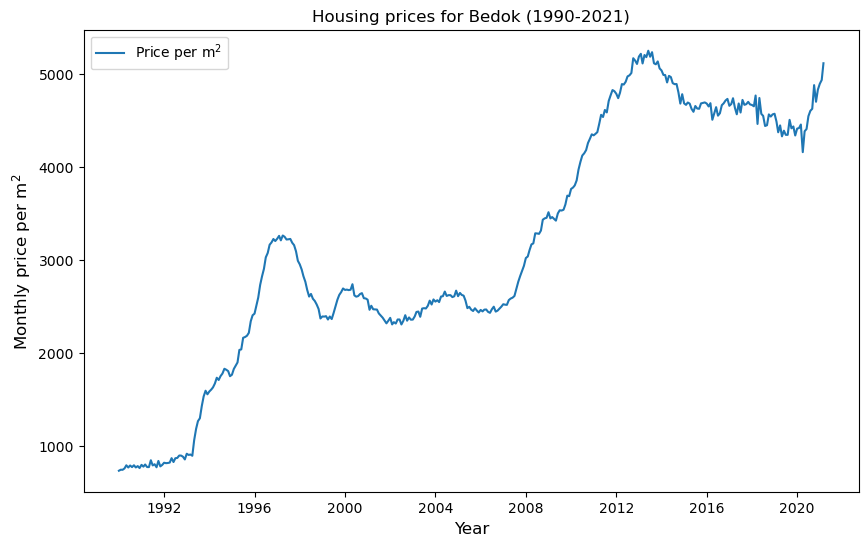

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
filepath = "../data/processed/bedok_processed.csv"
data = pd.read_csv(filepath, parse_dates=['timestamp'], index_col='timestamp')

# Explicitly setting to monthly frequency (important with exact intervals for time series modelling)
data = data.asfreq("MS")

# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(data, label="Price per m$^2$")
plt.title("Housing prices for Bedok (1990-2021)")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Monthly price per m$^2$", fontsize=12)
plt.legend()
plt.show()

#unimpoprtnat comment

### Building an ARIMA model

In [2]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model (parameters: p=1, d=1, q=1)
model = ARIMA(data["price_psm"], order=(1, 1, 1))
model_fit = model.fit()

# Print model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              price_psm   No. Observations:                  375
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -2086.263
Date:                Wed, 19 Mar 2025   AIC                           4178.526
Time:                        16:18:14   BIC                           4190.299
Sample:                    01-01-1990   HQIC                          4183.200
                         - 03-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9591      0.036     26.904      0.000       0.889       1.029
ma.L1         -0.8769      0.050    -17.427      0.000      -0.976      -0.778
sigma2      4096.1611    187.538     21.842      0.0

### Testing for stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller

# Perform the Augmented Dickey-Fuller test
result = adfuller(data["price_psm"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Interpret the results
if result[1] > 0.05:
    print("The data is not stationary.")
else:
    print("The data is stationary.")

ADF Statistic: -1.0468764530838957
p-value: 0.7357857693726149
The data is not stationary.


### Applying differencing to make the data stationary, by removing trends

ADF Statistic: -4.628443879933005
p-value: 0.00011444296965842411
The data is stationary.


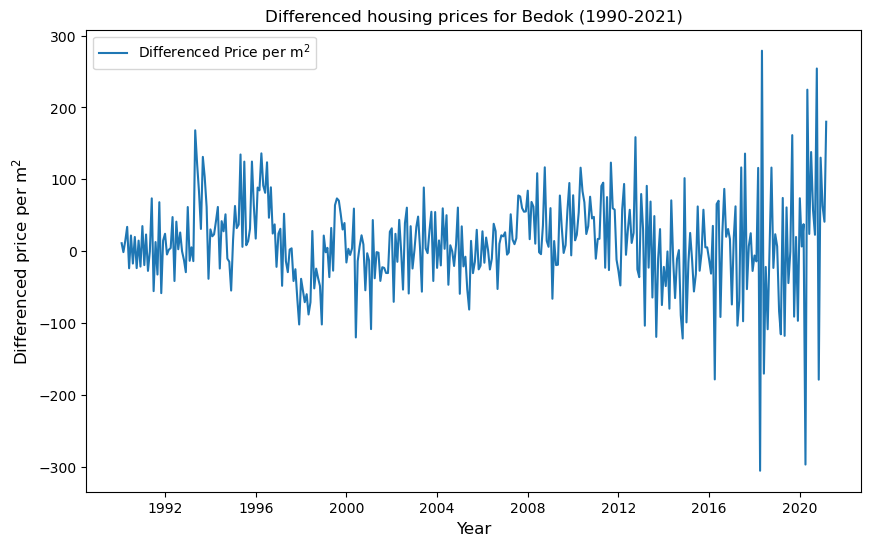

In [4]:
# Compute the first difference of the time series
data_diff = data["price_psm"].diff().dropna()

# Perform the Augmented Dickey-Fuller test
result = adfuller(data_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Interpret the results
if result[1] > 0.05:
    print("The data is not stationary.")
else:
    print("The data is stationary.")

# Plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(data_diff, label="Differenced Price per m$^2$")
plt.title("Differenced housing prices for Bedok (1990-2021)")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Differenced price per m$^2$", fontsize=12)
plt.legend()
plt.show()

### Determining parameters - ACF and PACF

Statistically significant spikes: Any bar that extends beyond the blue confidence interval.

When looking at the plots we can see that most spikes are within the confidence interval.

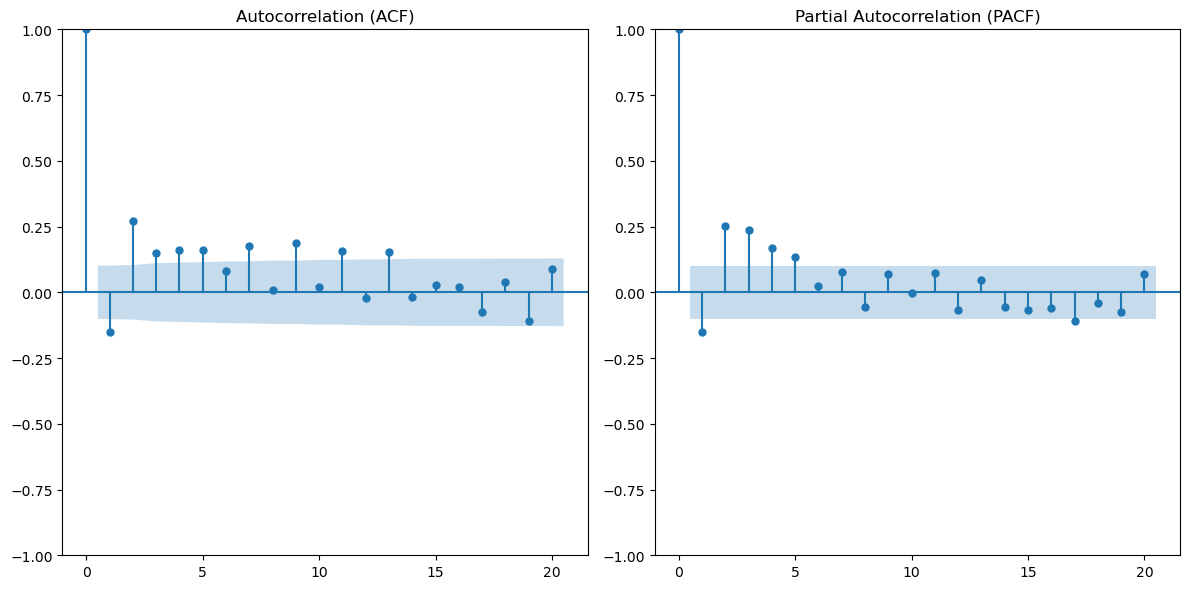

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for differenced data
plt.figure(figsize=(12, 6))

# ACF Plot
plt.subplot(1, 2, 1)
plot_acf(data_diff, lags=20, ax=plt.gca())
plt.title("Autocorrelation (ACF)")

# PACF Plot
plt.subplot(1, 2, 2)
plot_pacf(data_diff, lags=20, ax=plt.gca())
plt.title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

### Properly fitting the ARIMA model
(I just chose 2,1,1 here)

In [12]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA model with new parameters (p, d, q)
model = ARIMA(data["price_psm"], order=(2, 1, 1))

# Fit the model
model_fit = model.fit()

# Display the model summary
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              price_psm   No. Observations:                  375
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -2059.244
Date:                Tue, 18 Mar 2025   AIC                           4126.487
Time:                        14:22:29   BIC                           4142.184
Sample:                    01-01-1990   HQIC                          4132.720
                         - 03-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5210      0.060      8.752      0.000       0.404       0.638
ar.L2          0.3958      0.037     10.579      0.000       0.322       0.469
ma.L1         -0.7364      0.063    -11.681      0.0

/opt/anaconda3/envs/ntnu_std/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


### Observations
ARIMA (1,1,1):
- Includes AR(1) and MA(1)
- AIC: 4178.5
- BIC: 4790.3

ARIMA (2,1,1):
- Includes AR(2) and MA(1)
- AIC: 4126.5
- BIC: 4142.2

Lower AIC/BIC is better, so ARIMA(2,1,1) outperforms ARIMA(1,1,1)

With ARIMA(3,1,1) we get:
- AIC: 4125.9
- BIC: 4145.6

With ARIMA(2,1,2) we get:
- AIC: 4125.6
- BIC: 4145.2

So ARIMA(2,1,1) is still the best


#### TODO: implement seasonal ARIMA